# Deep Neuro-Fuzzy Systems (DNFS)


This notebook is written and maintained by **Amr Barakat**.

🔗 GitHub Repository: [https://github.com/amrcool/Deep-Neuro-Fuzzy-Systems-DNFS](https://github.com/amrcool/Deep-Neuro-Fuzzy-Systems-DNFS-)



### Data Preparation Steps

1. **Loading the Data:**
   The dataset is loaded from a CSV file using a semicolon (`;`) as the separator and a comma (`,`) as the decimal point to correctly parse the data.

2. **Data Cleaning:**
   Irrelevant or empty columns are dropped. All values are converted to numeric types, with invalid parsing replaced by NaN. Rows containing any NaN values are then removed to ensure clean data.

3. **Feature Selection:**
   Important features related to air quality are selected to be used as model inputs.

4. **Target Classification:**
   Raw CO (carbon monoxide) values are converted into categorical air quality classes: Good, Moderate, and Poor.

5. **Data Normalization:**
   Features are scaled to a \[0, 1] range using Min-Max scaling to help improve model training stability.

6. **Data Splitting:**
   The dataset is split into training (80%) and testing (20%) sets to evaluate model performance on unseen data.


In [11]:
import pandas as pd

In [12]:
# Define the full file path to the dataset
file_path = "air quality/AirQualityUCI.csv"

# Load the dataset using ';' as a separator and ',' as the decimal point
# 'engine=python' helps handle complex CSV formatting
df = pd.read_csv(file_path, sep=';', decimal=',', engine='python')

# Drop irrelevant or empty columns that do not contribute to the model
df.drop(columns=["Date", "Time", "", "Unnamed: 15", "Unnamed: 16"], errors='ignore', inplace=True)

# Convert all values in the DataFrame to numeric
# If conversion fails, the value is replaced with NaN
df = df.apply(pd.to_numeric, errors="coerce")

# Drop any rows with missing values to ensure clean training data
df.dropna(inplace=True)

# Display the first few rows of the cleaned dataset to verify structure
print(df.head())



   CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0     2.6       1360.0     150.0      11.9         1046.0    166.0   
1     2.0       1292.0     112.0       9.4          955.0    103.0   
2     2.2       1402.0      88.0       9.0          939.0    131.0   
3     2.2       1376.0      80.0       9.2          948.0    172.0   
4     1.6       1272.0      51.0       6.5          836.0    131.0   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  
0        1056.0    113.0        1692.0       1268.0  13.6  48.9  0.7578  
1        1174.0     92.0        1559.0        972.0  13.3  47.7  0.7255  
2        1140.0    114.0        1555.0       1074.0  11.9  54.0  0.7502  
3        1092.0    122.0        1584.0       1203.0  11.0  60.0  0.7867  
4        1205.0    116.0        1490.0       1110.0  11.2  59.6  0.7888  


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [14]:

# Select important features for air quality prediction
features = ["PT08.S1(CO)", "C6H6(GT)", "PT08.S2(NMHC)", "NOx(GT)", "PT08.S4(NO2)", "T", "RH"]
X = df[features].values  # Extract feature values as a NumPy array
y_raw = df["CO(GT)"].values  # Extract raw CO values as target for classification

# Define a function to classify air quality based on CO level
def classify_air_quality(co):
    if co < 2.0:
        return 0  # Good
    elif co <= 5.0:
        return 1  # Moderate
    else:
        return 2  # Poor

# Apply the classification function to each CO value to get class labels
y = np.array([classify_air_quality(co) for co in y_raw])

# Normalize feature values to range [0, 1] using Min-Max scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# FuzzyLayer: Membership Function Evaluation Layer

### 🔹 `FuzzyLayer`: Membership Function Evaluation Layer

* **Purpose**: This layer computes how much each input value belongs to fuzzy sets (Low, Medium, High, etc.) using **Gaussian membership functions**.
* **Learnable Parameters**:

  * `mu`: Centers of Gaussian functions (where the membership degree is 1).
  * `sigma`: Spread/width of each Gaussian (controls the fuzziness).
* **Output**: A tensor of shape `[batch_size, input_dim * num_mfs]` representing all membership degrees.




In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [16]:
class FuzzyLayer(nn.Module):
    def __init__(self, input_dim, num_mfs):
        super(FuzzyLayer, self).__init__()
        self.input_dim = input_dim
        self.num_mfs = num_mfs  # Number of membership functions per input feature

        # Parameters: mean (center) and standard deviation (spread) for each Gaussian MF
        self.mu = nn.Parameter(torch.rand(input_dim, num_mfs))    # Learnable centers of Gaussians
        self.sigma = nn.Parameter(torch.rand(input_dim, num_mfs)) # Learnable spreads of Gaussians

    def forward(self, x):
        batch_size = x.size(0)
        out = []

        # For each input feature, compute its membership values
        for i in range(self.input_dim):
            x_i = x[:, i].unsqueeze(1)         # Extract column i → shape: [batch, 1]
            mu_i = self.mu[i].unsqueeze(0)     # Center parameters for this feature → [1, num_mfs]
            sigma_i = self.sigma[i].unsqueeze(0) + 1e-6  # Avoid division by zero

            # Gaussian membership function: exp(-0.5 * ((x - mu)/sigma)^2)
            mf = torch.exp(-0.5 * ((x_i - mu_i) / sigma_i) ** 2)  # Output: [batch, num_mfs]
            out.append(mf)

        # Concatenate membership values from all input features → shape: [batch, input_dim * num_mfs]
        return torch.cat(out, dim=1)


### 🔹 `RuleLayer`: Fuzzy Rule Combination Layer

* **Purpose**: This layer evaluates the **activation strength** of all possible fuzzy rules by combining membership values from the previous layer.
* **Mechanism**:

  * It constructs all possible rules (e.g., `IF Temp is Low AND Humidity is High THEN ...`).
  * For each rule, it selects the relevant membership degrees for each input feature.
  * It computes the rule strength by **multiplying** these values (representing fuzzy logical AND).
* **Output**: Tensor of shape `[batch_size, num_rules]` where each element is the activation strength of one fuzzy rule.

In [17]:
class RuleLayer(nn.Module):
    def __init__(self, input_dim, num_mfs):
        super(RuleLayer, self).__init__()
        self.input_dim = input_dim
        self.num_mfs = num_mfs
        self.num_rules = num_mfs ** input_dim  # Total number of possible fuzzy rules

        # Generate all possible combinations of MF indices across input features
        import itertools
        self.rule_indices = list(itertools.product(range(num_mfs), repeat=input_dim))

    def forward(self, membership_vals):
        batch_size = membership_vals.size(0)

        # Reshape membership values to [batch_size, input_dim, num_mfs]
        membership_vals = membership_vals.view(batch_size, self.input_dim, self.num_mfs)

        rule_outputs = []

        # Iterate through all possible fuzzy rules
        for rule in self.rule_indices:
            selected = []
            # For each feature, select the membership value specified in the rule
            for i, mf_idx in enumerate(rule):
                selected.append(membership_vals[:, i, mf_idx].unsqueeze(1))  # Shape: [batch, 1]

            # Combine the selected membership values using product (fuzzy AND)
            rule_strength = torch.prod(torch.cat(selected, dim=1), dim=1, keepdim=True)  # [batch, 1]
            rule_outputs.append(rule_strength)

        # Concatenate the strengths of all rules → shape: [batch, num_rules]
        return torch.cat(rule_outputs, dim=1)

### 🔹 `OutputLayer`: Defuzzification via Fully Connected Layer


* **Purpose**: This layer performs **defuzzification** by mapping the rule activation strengths into the final **class scores** (e.g., air quality classes).
* **Mechanism**:

  * Takes the output from the `RuleLayer` (i.e., the strength of all rules).
  * Passes it through a **fully connected (dense) layer** to compute the final prediction.
  * During training, the weights of this layer are adjusted to optimize classification performance.
* **Input Shape**: `[batch_size, num_rules]`
* **Output Shape**: `[batch_size, output_dim]`
  where `output_dim` is typically the number of classes (e.g., 3 for "Good", "Moderate", "Bad").



In [18]:
class OutputLayer(nn.Module):
    def __init__(self, num_rules, output_dim):
        super(OutputLayer, self).__init__()
        self.fc = nn.Linear(num_rules, output_dim)

    def forward(self, x):
        return self.fc(x)


### 🔹 DNFSModel: Deep Neuro-Fuzzy System Architecture


### Explanation of the Model Structure:

1. **Fuzzy Layer (`self.fuzzy`)**

   * Transforms crisp input features into fuzzy membership values using Gaussian functions.
   * For each input variable, computes how much it belongs to each fuzzy set (e.g., Low, High).

2. **Rule Layer (`self.rules`)**

   * Enumerates all possible fuzzy rules by combining membership functions from each feature.
   * Computes the *firing strength* of each rule by multiplying membership values (logical AND).

3. **Output Layer (`self.output`)**

   * Maps the strength of all rules to output classes using a linear transformation.
   * These outputs can then be interpreted as class scores or probabilities after applying softmax externally.


### How Forward Pass Works:

* Input vector `x` (e.g., air quality sensor readings) →
* `FuzzyLayer` converts each input to degrees of membership →
* `RuleLayer` calculates activation strengths for every fuzzy rule →
* `OutputLayer` combines these activations to produce final class logits.



In [19]:
class DNFSModel(nn.Module):
    def __init__(self, input_dim, num_mfs, output_dim):
        super(DNFSModel, self).__init__()
        self.fuzzy = FuzzyLayer(input_dim, num_mfs)
        self.rules = RuleLayer(input_dim, num_mfs)
        self.output = OutputLayer(num_mfs ** input_dim, output_dim)

    def forward(self, x):
        mf = self.fuzzy(x)
        rule_out = self.rules(mf)
        return self.output(rule_out)



### 🔹 Training The Model with


### Step-by-step Explanation:

1. **Model Definition (DNFSModel placeholder)**

   * A simple model using a `Linear` layer as a placeholder for your actual DNFSModel.
   * In your real application, replace this with your custom deep neuro-fuzzy model.

2. **Data Preparation**

   * Convert training and testing data into `torch.tensor` with appropriate data types (`float32` for inputs, `long` for labels).
   * Create a `TensorDataset` and `DataLoader` to batch the data (`batch_size=64`) and shuffle it during training.

3. **Model, Loss Function, Optimizer Initialization**

   * Initialize the model, the loss function (`CrossEntropyLoss` for multi-class classification), and the optimizer (`Adam`) with a learning rate of 0.01.

4. **Training Loop**

   * Loop through a number of epochs.
   * For each batch:

     * Compute predictions `preds` from the model.
     * Calculate the loss between predictions and true labels.
     * Zero the gradients with `optimizer.zero_grad()`.
     * Backpropagate gradients `loss.backward()`.
     * Update the model parameters `optimizer.step()`.
   * Calculate the average loss for each epoch and save it for later plotting.

5. **Plotting the Loss Curve**

   * Use `matplotlib` to plot the loss curve across epochs to visually monitor the training progress.

6. **Evaluation**

   * Set the model to evaluation mode `model.eval()` to disable behaviors like dropout.
   * Predict labels on the test set.
   * Extract predicted classes by taking the index of the max output probability.



In [20]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


In [21]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)



In [22]:

input_dim = X_train.shape[1]
num_mfs = 2
output_dim = 3

model = DNFSModel(input_dim, num_mfs, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()


In [23]:

loss_history = []

for epoch in range(22):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        preds = model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")

Epoch 1 - Loss: 0.4046
Epoch 2 - Loss: 0.3190
Epoch 3 - Loss: 0.3183
Epoch 4 - Loss: 0.2987
Epoch 5 - Loss: 0.2979
Epoch 6 - Loss: 0.2947
Epoch 7 - Loss: 0.2892
Epoch 8 - Loss: 0.2845
Epoch 9 - Loss: 0.2869
Epoch 10 - Loss: 0.2849
Epoch 11 - Loss: 0.2794
Epoch 12 - Loss: 0.2805
Epoch 13 - Loss: 0.2816
Epoch 14 - Loss: 0.2847
Epoch 15 - Loss: 0.2801
Epoch 16 - Loss: 0.2824
Epoch 17 - Loss: 0.2818
Epoch 18 - Loss: 0.2778
Epoch 19 - Loss: 0.2790
Epoch 20 - Loss: 0.2792
Epoch 21 - Loss: 0.2784
Epoch 22 - Loss: 0.2758


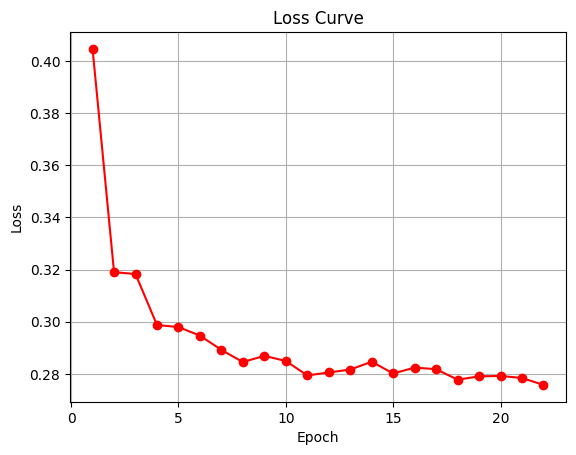

In [24]:

plt.plot(range(1, len(loss_history)+1), loss_history, marker='o', color='red')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

              precision    recall  f1-score   support

         جيد       0.96      0.91      0.93      1166
       متوسط       0.83      0.90      0.86       631
         سيء       0.79      0.77      0.78        75

    accuracy                           0.90      1872
   macro avg       0.86      0.86      0.86      1872
weighted avg       0.91      0.90      0.90      1872

Test Accuracy: 90.28%


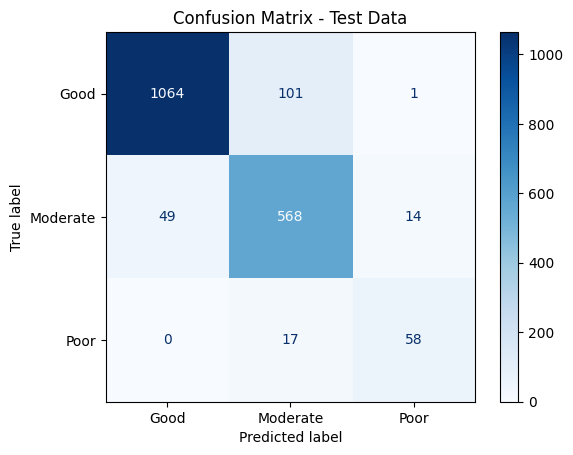

In [26]:

model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor)
    predicted_labels = torch.argmax(test_preds, dim=1)


print(classification_report(y_test, predicted_labels, target_names=["جيد", "متوسط", "سيء"]))

accuracy = accuracy_score(y_test_tensor.numpy(), predicted_labels.numpy())
print(f"Test Accuracy: {accuracy*100:.2f}%")

cm = confusion_matrix(y_test_tensor.numpy(), predicted_labels.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Good", "Moderate", "Poor"])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Data")
plt.grid(False)
plt.show()


### 🔹 Displaying Fuzzy Rules and Their Learned Weights from the DNFS Model


### Explanation:

* **Purpose:**
  This function prints out all the fuzzy inference rules generated by the model, showing the conditions for each input variable and the corresponding output class ("Good", "Average", "Poor") along with the learned weight for that rule.

* **Inputs:**

  * `model`: Your trained DNFSModel instance.
  * `terms`: The linguistic terms assigned to each membership function index (here, "Low" or "High").
  * `variables`: Names of the input variables corresponding to each feature.
  * `rules`: All possible combinations of membership function indices for the input variables (e.g., Low-High-Low-...).
  * `weights`: The learned weights from the model’s output layer representing the influence strength of each rule on each output class.

* **How it works:**

  1. Generates all possible fuzzy rules as combinations of terms for each variable.
  2. Retrieves the output layer weights from the model (converted to a NumPy array).
  3. For each rule, builds a textual condition string that shows the fuzzy label for each input.
  4. For each output class (quality level), prints the rule’s condition and the corresponding weight learned during training.


In [27]:
import itertools

In [29]:
def display_rules(model):
    terms = ["Low", "High"]
    variables = ["S1(CO)", "C6H6", "S2(NMHC)", "NOx", "NO2", "T", "RH"]

    rules = list(itertools.product(range(num_mfs), repeat=input_dim))
    weights = model.output.fc.weight.detach().numpy()
    
    for i, rule in enumerate(rules):

        conditions = [f"{var} is {terms[term]}" for var, term in zip(variables, rule)]
        for c in range(output_dim):
            print(f"If {' AND '.join(conditions)} THEN Quality = {['Good', 'Moderate', 'Bad'][c]} (weight={weights[c][i]:.3f})")


In [30]:
display_rules(model)

If S1(CO) is Low AND C6H6 is Low AND S2(NMHC) is Low AND NOx is Low AND NO2 is Low AND T is Low AND RH is Low THEN Quality = Good (weight=-0.043)
If S1(CO) is Low AND C6H6 is Low AND S2(NMHC) is Low AND NOx is Low AND NO2 is Low AND T is Low AND RH is Low THEN Quality = Moderate (weight=0.245)
If S1(CO) is Low AND C6H6 is Low AND S2(NMHC) is Low AND NOx is Low AND NO2 is Low AND T is Low AND RH is Low THEN Quality = Bad (weight=-1.305)
If S1(CO) is Low AND C6H6 is Low AND S2(NMHC) is Low AND NOx is Low AND NO2 is Low AND T is Low AND RH is High THEN Quality = Good (weight=-0.119)
If S1(CO) is Low AND C6H6 is Low AND S2(NMHC) is Low AND NOx is Low AND NO2 is Low AND T is Low AND RH is High THEN Quality = Moderate (weight=0.374)
If S1(CO) is Low AND C6H6 is Low AND S2(NMHC) is Low AND NOx is Low AND NO2 is Low AND T is Low AND RH is High THEN Quality = Bad (weight=-1.247)
If S1(CO) is Low AND C6H6 is Low AND S2(NMHC) is Low AND NOx is Low AND NO2 is Low AND T is High AND RH is Low THEN Q